In [13]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import warnings
import numpy.ma as ma
import copy

In [2]:
def _matrix_mask(data, mask):
    """from seaborn: https://github.com/mwaskom/seaborn/blob/430c1bf1fcc690f0431e6fc87b481b7b43776594/seaborn/matrix.py"""
    """Ensure that data and mask are compatible and add missing values.
    Values will be plotted for cells where ``mask`` is ``False``.
    ``data`` is expected to be a DataFrame; ``mask`` can be an array or
    a DataFrame.
    """
    if mask is None:
        mask = np.zeros(data.shape, bool)

    if isinstance(mask, np.ndarray):
        # For array masks, ensure that shape matches data then convert
        if mask.shape != data.shape:
            raise ValueError("Mask must have the same shape as data.")

        mask = pd.DataFrame(mask,
                            index=data.index,
                            columns=data.columns,
                            dtype=bool)

In [3]:
LD_out = "sl-cov_ld_genome_out.csv"
masterdat = pd.read_csv(LD_out,skiprows=9)

In [4]:
##add a y column
masterdat["y"] = masterdat["x"]+masterdat["l"]
##get conditional probability
masterdat["P(X|Y)"] = masterdat["P11"]/masterdat["P1b"]
##calc covXY
masterdat["covXY"] = masterdat["P11"] - masterdat["P1a"]*masterdat["P1b"]
##calc PCC
##get variance of X and Y for the position
one = np.ones(len(masterdat["P1a"]))
masterdat["varX"] = masterdat["P1a"]*(one-masterdat["P1a"])
masterdat["varY"] = masterdat["P1b"]*(one-masterdat["P1b"])
masterdat["PCC"] = masterdat["covXY"]/(np.sqrt(masterdat["varX"]*masterdat["varY"]))
masterdat.head()

,x,l,P11,P1a,P1b,n,t,g,pos,y,P(X|Y),covXY,varX,varY,PCC
0,7125,72,0.133034,0.156898,0.332584,13786,Qs,all CDS,NaN,7197,0.400000,0.080852,0.132281,0.221972,0.471836
1,15996,72,0.000061,0.010989,0.010989,16471,Qs,all CDS,NaN,16068,0.005525,-0.000060,0.010868,0.010868,-0.005525
2,23235,72,0.029382,0.031408,0.146910,17766,Qs,all CDS,NaN,23307,0.200000,0.024768,0.030422,0.125327,0.401117
3,24540,72,0.000000,0.000000,0.234918,15631,Qs,all CDS,NaN,24612,0.000000,0.000000,0.000000,0.179731,NaN
4,8325,72,0.000000,0.000000,0.000000,11026,Qs,all CDS,NaN,8397,NaN,0.000000,0.000000,0.000000,NaN


In [5]:
np.max(masterdat["x"])

29262

### save genome-wide maps of correlations (cov(X,Y), PCC, P(X|Y)) in matrix form as pickles for later use)

In [6]:
##sort by position
orderedpos = masterdat.sort_values(["x", "y"])
##prep the correlation matrix for plotting
geneclusterdat = orderedpos
##get pearson's
Pxy = np.nan_to_num(list(geneclusterdat["PCC"]), nan=0)
genecorrdat = pd.DataFrame({"x": list(geneclusterdat["x"]), 
                            "y":list(geneclusterdat["y"]), 
                            "Pxy":Pxy})
PCC = genecorrdat.pivot(index="y", columns="x", values="Pxy")
PCC.to_pickle("PCC_noNaNs_matrix.pkl.gz")
## get PCC with NaN values
genecorrdat = pd.DataFrame({"x": list(geneclusterdat["x"]), 
                            "y":list(geneclusterdat["y"]), 
                            "Pxy":list(geneclusterdat["PCC"])})
PCCnans = genecorrdat.pivot(index="y", columns="x", values="Pxy")
PCCnans.to_pickle("PCC_withNaNs_matrix.pkl.gz")
###get the covariance matrix ...
genecorrdat = pd.DataFrame({"x": list(geneclusterdat["x"]), 
                            "y":list(geneclusterdat["y"]), 
                            "Pxy":list(geneclusterdat["covXY"])})
covXY = genecorrdat.pivot(index="y", columns="x", values="Pxy")
covXY.to_pickle("covXYwithNaNs_matrix.pkl.gz")

In [7]:
##sort by position
orderedpos = masterdat.sort_values(["x", "y"])
##prep the correlation matrix for plotting
geneclusterdat = orderedpos
##get pearson's
Pxy = np.nan_to_num(list(geneclusterdat["P(X|Y)"]), nan=0)
genecorrdat = pd.DataFrame({"x": list(geneclusterdat["x"]), 
                            "y":list(geneclusterdat["y"]), 
                            "Pxy":Pxy})
Pxy = genecorrdat.pivot(index="y", columns="x", values="Pxy")
Pxy.to_pickle("Pxy_noNaNs_matrix.pkl.gz")

## can skip the above if you have pickles saved already ..

In [8]:
PCC = pd.read_pickle("PCC_noNaNs_matrix.pkl.gz")

In [9]:
##get CDS stop sites
CDS = [4401, 2696, 1274, 276, 76, 223, 62, 122, 44, 122, 420, 39]
CDS_len = []
pos = 0
for x in CDS:
    pos = pos + x
    CDS_len.append(pos)
    
CDS_stop = CDS_len - np.ones(len(CDS_len)) 

CDS_len = np.array(CDS_len)
gene_blocks = 1-CDS_len/9755

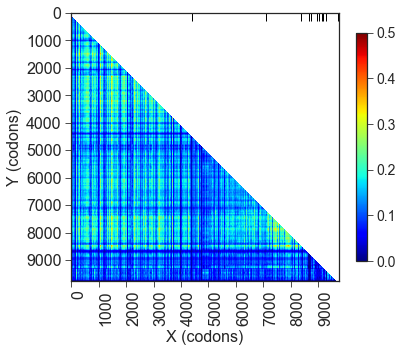

In [14]:
plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize=(6,6))
low = 25
high = 80
#vmin, vmax = set_bounds(PCC, low, high)
cm = matplotlib.cm.jet
cm2 = copy.copy(cm)
cm2.set_bad('white',1.)
im = ax.imshow(PCC, cmap=cm2, interpolation="bicubic",vmin=0, vmax=0.5)
fontsize=16
titlefont=16
ax.locator_params(axis='y', nbins=10)
ax.locator_params(axis='x', nbins=10)
ax.tick_params(axis='both', labelsize=fontsize)
cb = fig.colorbar(im, ax=ax, shrink=0.7)
cb.ax.tick_params(labelsize=14)
# ax.set_yticklabels(pos_array)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", fontsize=fontsize)
ax.set_xlabel("X (codons)", fontsize=titlefont)
ax.set_ylabel("Y (codons)", fontsize=titlefont)
#plt.yticks(fontsize=12)
#ax.set_title("PCC (Bicubic)",fontsize=14)
xpos = CDS_stop[:-1]
plt.vlines(x=xpos, ymax=300, 
               ymin=0, color="black", linewidth=1)
fig.savefig("pcc_example.png", bbox_inches='tight', dpi=300)
plt.show()